Injured: 261, Not Injured: 282
Found 435 images belonging to 2 classes.
Found 108 images belonging to 2 classes.
Class indices : {'injured_animals': 0, 'not_injured_animals': 1}
Train class distribution : [209 226]
Validation class distribution : [52 56]


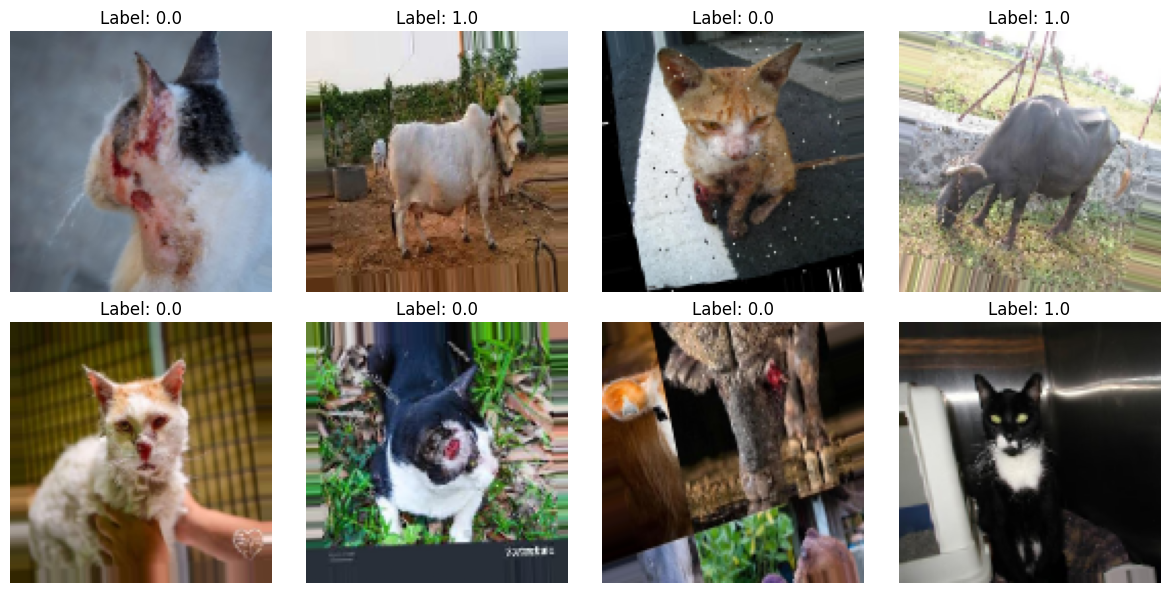

Class weights : {0: 1.0406698564593302, 1: 0.9623893805309734}
Epoch 1/10
14/14 [==============================] - 6s 427ms/step - loss: 0.7001 - accuracy: 0.5034 - val_loss: 0.6926 - val_accuracy: 0.4815 - lr: 1.0000e-04
Epoch 2/10
14/14 [==============================] - 6s 414ms/step - loss: 0.6995 - accuracy: 0.5080 - val_loss: 0.6915 - val_accuracy: 0.5556 - lr: 1.0000e-04
Epoch 3/10
14/14 [==============================] - 6s 413ms/step - loss: 0.6826 - accuracy: 0.5333 - val_loss: 0.6890 - val_accuracy: 0.5093 - lr: 1.0000e-04
Epoch 4/10
14/14 [==============================] - 6s 410ms/step - loss: 0.6763 - accuracy: 0.5885 - val_loss: 0.6874 - val_accuracy: 0.5648 - lr: 1.0000e-04
Epoch 5/10
14/14 [==============================] - 5s 386ms/step - loss: 0.6593 - accuracy: 0.6299 - val_loss: 0.6914 - val_accuracy: 0.5278 - lr: 1.0000e-04
Epoch 6/10
14/14 [==============================] - 5s 388ms/step - loss: 0.6606 - accuracy: 0.5885 - val_loss: 0.6963 - val_accuracy: 0.5278 

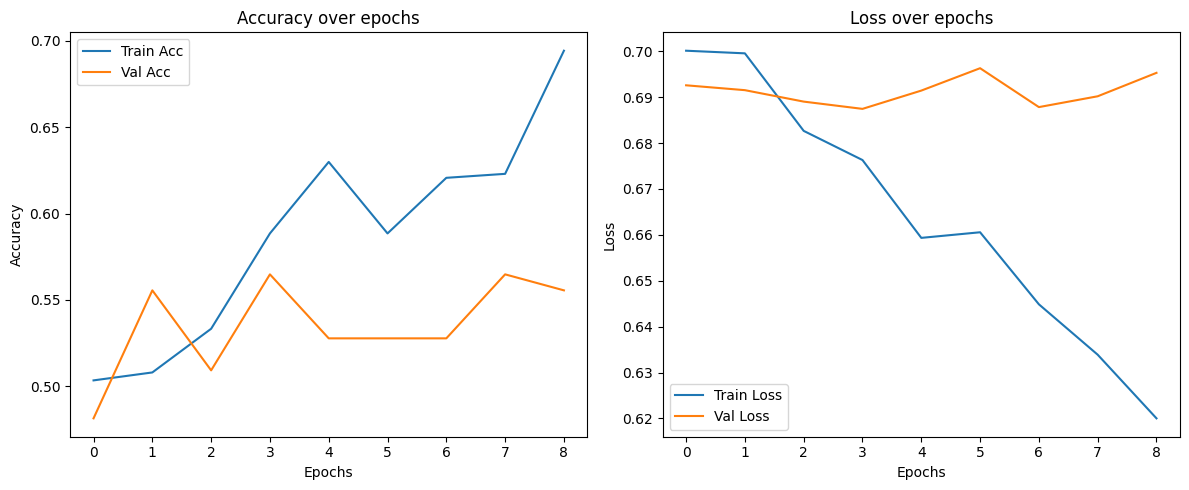

4/4 [==============================] - 1s 137ms/step


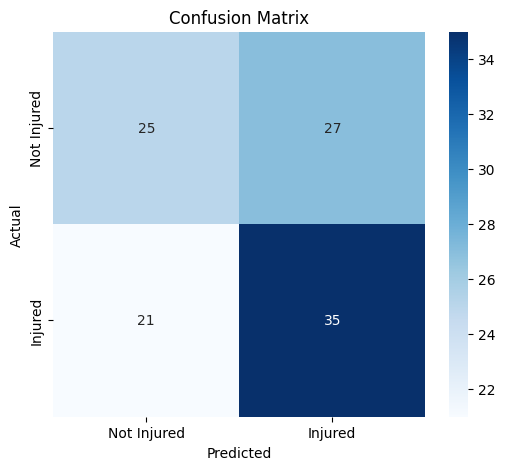

              precision    recall  f1-score   support

 Not Injured       0.54      0.48      0.51        52
     Injured       0.56      0.62      0.59        56

    accuracy                           0.56       108
   macro avg       0.55      0.55      0.55       108
weighted avg       0.55      0.56      0.55       108



In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 📁 Dossier images
dataset_path = '../dataset_corrige_animals/'

# 📊 Vérification du nombre d'images dans chaque dossier
injured_count = len(os.listdir(os.path.join(dataset_path, 'injured_animals')))
not_injured_count = len(os.listdir(os.path.join(dataset_path, 'not_injured_animals')))

print(f"Injured: {injured_count}, Not Injured: {not_injured_count}")

# 📊 Data Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2
)

train_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=(128,128),
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=(128,128),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

# 📌 Mapping des classes
print("Class indices :", train_gen.class_indices)

# 📈 Distribution des classes dans les générateurs
print("Train class distribution :", np.bincount(train_gen.classes))
print("Validation class distribution :", np.bincount(val_gen.classes))

# 📸 Visualiser des images et leurs labels
images, labels = next(train_gen)

plt.figure(figsize=(12,6))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(images[i])
    plt.title(f"Label: {labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# 📊 Class weights
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weights = dict(enumerate(class_weights))
print("Class weights :", class_weights)

# 📦 Petit CNN custom
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# ⚙️ Compilation
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# 📉 Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
]

# 📊 Entraînement
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weights,
    callbacks=callbacks
)

# 📈 Courbes Loss / Accuracy
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 📊 Évaluation finale
val_gen.reset()
preds = model.predict(val_gen)
pred_classes = (preds > 0.5).astype(int).reshape(-1)

# 📉 Matrice de confusion
cm = confusion_matrix(val_gen.classes, pred_classes)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Not Injured', 'Injured'],
            yticklabels=['Not Injured', 'Injured'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 📄 Rapport de classification
target_names = ['Not Injured', 'Injured']
print(classification_report(val_gen.classes, pred_classes, target_names=target_names))
